In [9]:
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import numpy as np
import rich.table
import geopandas as gpd
import datetime

In [20]:
# Open the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

yosemite_boundary = gpd.read_file('Shapefiles/Yosemite_Boundary_4326.shp')
bbox_of_interest = yosemite_boundary.total_bounds.tolist() 
print(bbox_of_interest)

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=50)
time_of_interest = f"{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"
print(time_of_interest)

search = catalog.search(
    collections=["sentinel-1-grd"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

[-119.88628746686305, 37.49221278371785, -119.19950431700676, 38.18646166998004]
2023-12-24/2024-02-12
Returned 9 Items


In [43]:
# Render a preview
from IPython.display import Image

item = items[8]
Image(url=item.assets["rendered_preview"].href)

In [44]:
# Display a table of results metadata
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                       │
│ datetime                              │ 2023-12-27T01:59:58.830912Z      │
│ end_datetime                          │ 2023-12-27 02:00:11.330527+00:00 │
│ platform                              │ SENTINEL-1A                      │
│ s1:datatake_id                        │ 410357                           │
│ s1:instrument_configuration_ID        │ 7                                │
│ s1:orbit_source                       │ RESORB                           │
│ s1:processing_level                   │ 1                                │
│ s1:product_timeliness                 │ Fast-24h                         │
│ s1:resolution                         │ high                             │
│ s1:shape                              │ [26326, 16677]                   │
│ s1:slice_number                       │ 4                                │
│ s1:total_slices                       │ 26                               │
│ sar:center_frequency                  │ 5.405                            │
│ sar:frequency_band                    │ C                                │
│ sar:instrument_mode                   │ IW                               │
│ sar:looks_azimuth                     │ 1                                │
│ sar:looks_equivalent_number           │ 4.4                              │
│ sar:looks_range                       │ 5                                │
│ sar:observation_direction             │ right                            │
│ sar:pixel_spacing_azimuth             │ 10                               │
│ sar:pixel_spacing_range               │ 10                               │
│ sar:polarizations                     │ ['VV', 'VH']                     │
│ sar:product_type                      │ GRD                              │
│ sar:resolution_azimuth                │ 22                               │
│ sar:resolution_range                  │ 20                               │
│ sat:absolute_orbit                    │ 51834                            │
│ sat:orbit_state                       │ ascending                        │
│ sat:platform_international_designator │ 2014-016A                        │
│ sat:relative_orbit                    │ 137                              │
│ start_datetime                        │ 2023-12-27 01:59:46.331298+00:00 │
└───────────────────────────────────────┴──────────────────────────────────┘

In [5]:
# Load the bands

vv = (
    rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
    .astype(float)
    .squeeze()
)
vh = (
    rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
    .astype(float)
    .squeeze()
)

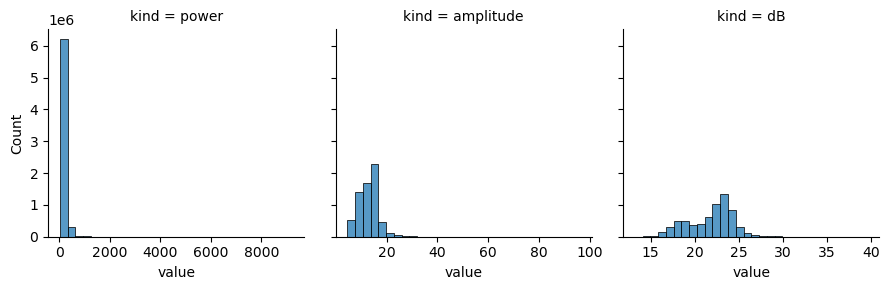

In [6]:
# Generate histograms
import pandas as pd
import seaborn as sns

raw = vv.where(lambda x: x > 0).data.ravel()
df = (
    pd.DataFrame({"power": raw, "amplitude": np.sqrt(raw), "dB": 10 * np.log10(raw)})
    .dropna()
    .melt(value_vars=["power", "amplitude", "dB"], var_name="kind")
)

g = sns.FacetGrid(df, sharex=False, col="kind")
g.map(sns.histplot, "value", bins=30)

c:\Users\Bachi\miniforge3\envs\gps_final\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


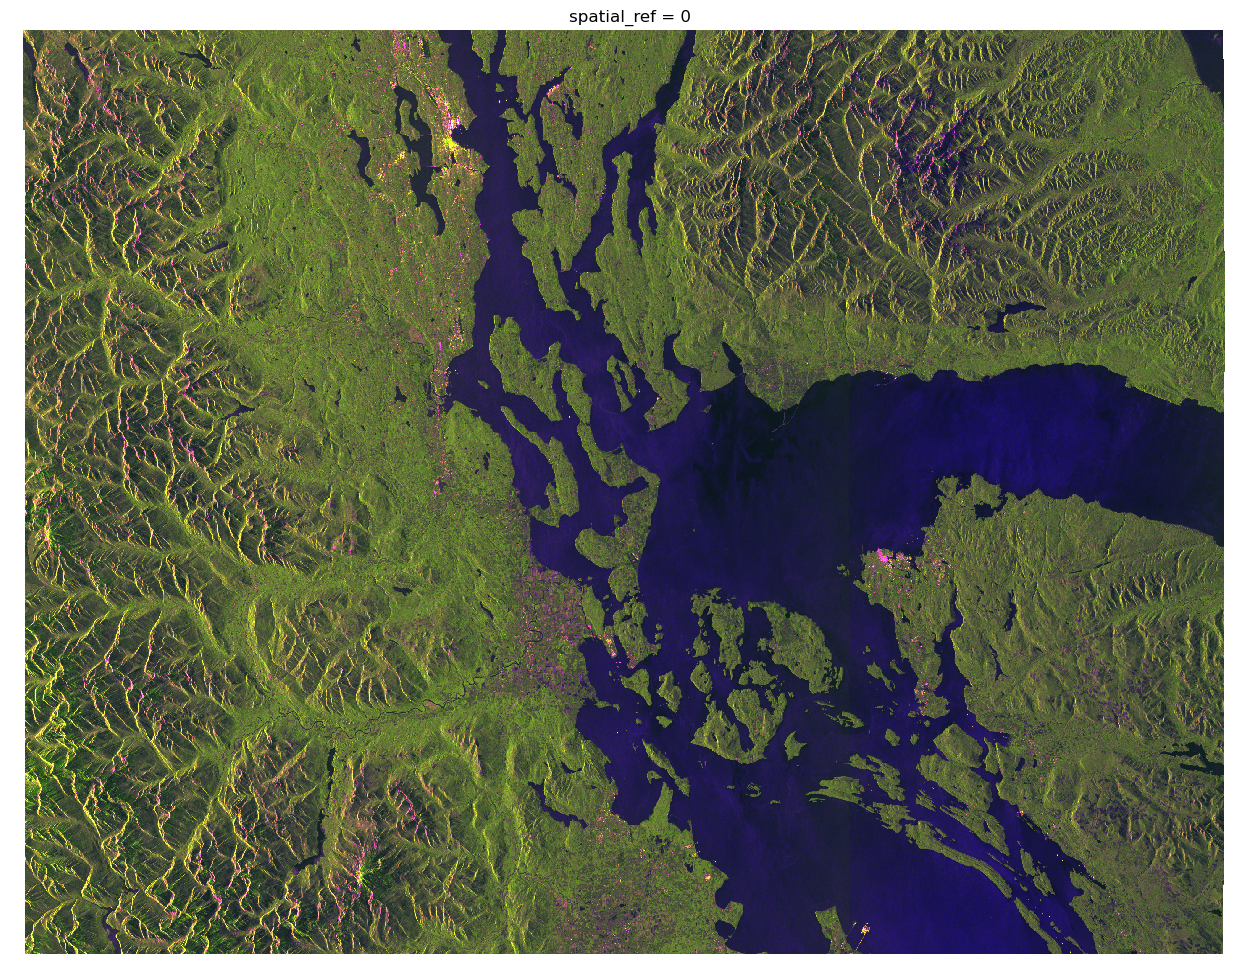

In [7]:
# Create false color image of the study area
r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)
img = data.plot.imshow(rgb="band", size=12)
img.axes.set_axis_off()

In [8]:
# Find orbit state. If the satellite is in 'descending' mode, the image will need to be flipped. Add IF statement later.
item.properties["sat:orbit_state"]

'descending'